In [ ]:
# Adatkezeléshez szükséges könyvtárak
import pandas as pd                   # Adatok betöltése és kezelése táblázatos formában (DataFrame)
import numpy as np                   # Numerikus számításokhoz, tömbkezeléshez

# Tanító és teszt adathalmaz szétválasztásához
from sklearn.model_selection import train_test_split

# Szövegek számosság-alapú átalakításához (bag-of-words modell)
from sklearn.feature_extraction.text import CountVectorizer

# Naiv Bayes modellek különböző változatai
from sklearn.naive_bayes import MultinomialNB     # Multinomiális NB (gyakori szövegmodellezésre)
from sklearn.naive_bayes import BernoulliNB       # Bernoulli NB (bináris jellemzőkre)
from sklearn.naive_bayes import GaussianNB        # Gauss NB (folytonos jellemzőkre)

# Reguláris kifejezések – szöveg előfeldolgozáshoz (pl. tisztítás)
import re

# Természetes nyelvfeldolgozáshoz (tokenizálás, lemmatizálás, stb.)
import nltk

# Lemmatizáló osztály az NLTK-ból – szavak alapalakra hozása
from nltk.stem import WordNetLemmatizer

# Operációs rendszerrel kapcsolatos műveletekhez (pl. fájlok kezelése)
import os

# Dimenziócsökkentés szövegjellemzőkön (pl. LSA, SVD)
from sklearn.decomposition import TruncatedSVD

# Tensorflow – gépi tanulási keretrendszer (pl. neurális hálókhoz)
import tensorflow as tf

# TensorFlow Hub – előre tanított modellek betöltéséhez (pl. BERT)
import tensorflow_hub as hub

# HuggingFace BERT tokenizáló – BERT-hez szöveg előkészítés
from transformers import BertTokenizer, BertModel, get_linear_schedule_with_warmup

# HuggingFace tanulási ütemező – tanítási lépések kontrollálása
from transformers import get_linear_schedule_with_warmup

# HuggingFace BERT modell – szöveg osztályozáshoz finomhangolható modell
from transformers import BertForSequenceClassification

# Adatvizualizációs könyvtárak
import matplotlib.pyplot as plt      # Ábrák és grafikonok készítése
import seaborn as sns                # Szebb, stílusosabb vizualizációk

# Újra: teljes metrikacsomag (néhány duplikált az előzőekkel, de így is működik)
from sklearn.metrics import (
    accuracy_score,                 # Pontosság
    confusion_matrix,               # Konfúziós mátrix
    classification_report,          # Precízió, recall, F1
    roc_auc_score,                  # ROC-görbe alatti terület
    log_loss                        # Logaritmikus veszteség
)

# PyTorch – mélytanulási keretrendszer
import torch

# AdamW optimalizáló – súlycsökkentett Adam algoritmus
from torch.optim import AdamW

from torch.utils.data import DataLoader, Dataset

# Neurális hálós modulok (pl. veszteségfüggvények)
import torch.nn as nn

# PyTorch Dataset és DataLoader – mini-batch tanításhoz
from torch.utils.data import TensorDataset, DataLoader

#Időmérés
import time

from peft import get_peft_model, LoraConfig, TaskType
from tqdm import tqdm

C:\Users\mihal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\mihal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [4]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mihal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mihal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
df=pd.read_csv("SPAMDATA.csv", encoding="utf-8")

In [7]:
df

filter                                               text
0            0  Subject: re : wolf - reply - reply - reply\n\n...
1            0  Subject: hilcorp old ocean\n\ni have continued...
2            0  Subject: merchanting metals update\n\nseveral ...
3            0  Subject: meter 6461 , concorde churchill\n\non...
4            0  Subject: weekly deal report\n\nattached is the...
...        ...                                                ...
271394       0  Subject: fw : crosstex energy , driscoll ranch...
271395       0  Subject: put the 10 on the ft\r\nthe transport...
271396       0  Subject: 3 / 4 / 2000 and following noms\r\nhp...
271397       0  Subject: industrial worksheets for august 2000...
271398       1  Subject: important online banking alert\r\ndea...

[271399 rows x 2 columns]

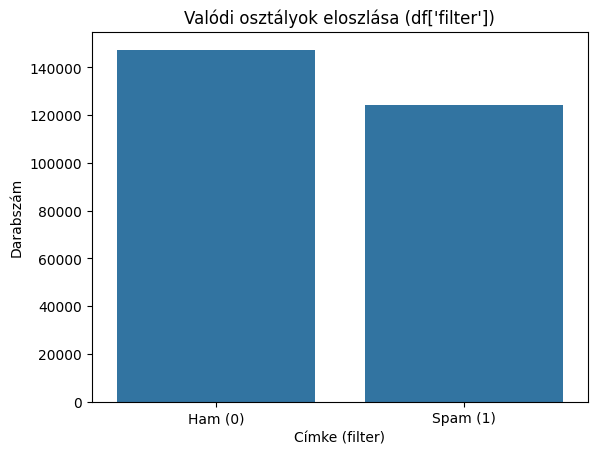

In [8]:
# Számoljuk meg, hogy az egyes címkék (0 vagy 1) hányszor fordulnak elő a 'filter' oszlopban,
# majd növekvő sorrendbe rendezzük (0, majd 1).
label_counts = df["filter"].value_counts().sort_index()

# Oszlopdiagramot rajzolunk az osztályok (0 és 1) előfordulásairól.
# A vízszintes tengelyen az osztályok (indexek), a függőleges tengelyen az előfordulások száma (values).
sns.barplot(x=label_counts.index, y=label_counts.values)

# Tengelyfeliratok és ábra címe:
plt.xlabel("Címke (filter)")              # X tengely felirata – ez a 0 és 1-es osztályokat jelenti
plt.ylabel("Darabszám")                   # Y tengely felirata – hány darab példa tartozik az adott osztályhoz
plt.title("Valódi osztályok eloszlása (df['filter'])")  # Ábra címe

# X tengely értékeit szebben megjelenítjük: 0 → 'Ham', 1 → 'Spam'
plt.xticks([0, 1], ['Ham (0)', 'Spam (1)'])

# Megjelenítjük az ábrát
plt.show()

In [9]:
# A df["text"] oszlop szöveges tartalmát kivesszük, és biztosítjuk, hogy minden elem string típusú legyen
# (ha lenne benne pl. NaN vagy más típus, az is szöveggé alakul)
x = df["text"].astype(str)

# Egy list comprehension segítségével eltávolítjuk minden e-mailből az URL-eket (linkeket).
# A reguláris kifejezés (regex) alapján minden olyan részt, ami "http"-vel kezdődik és nem tartalmaz szóközt ("\S+"),
# lecserélünk egy üres stringre: azaz töröljük őket.
x_clnd_link = [re.sub(r"http\S+", "", text) for text in x]

# Kiírjuk az első megtisztított e-mail szöveget (az első elem a listában)
print(x_clnd_link[0])

Subject: re : wolf - reply - reply - reply

wrong bill grace / i ' ll forward .
- - - - - original message - - - - -
from : rodriguez , grace
sent : friday , june 29 , 2001 9 : 23 am
to : fitzpatrick , amy ; williams , bill
subject : re : wolf - reply - reply - reply
please let me know who you would like to interview darrin , and when .
thanks !
- grace
- - - - - original message - - - - -
from : fitzpatrick , amy
sent : friday , june 29 , 2001 7 : 35 am
to : rodriguez , grace
subject : fw : wolf - reply - reply - reply
grace -
please schedule an interview for this candidate to meet with me , bill and anyone else that bill recommends . we need to treat this one ' right ' - he is the brother of a vp in houston . . . . . . . .
thanks !
amy
- - - - - original message - - - - -
from : wolfe , greg
sent : friday , june 29 , 2001 6 : 53 am
to : williams iii , bill ; fitzpatrick , amy
subject : fw : wolf - reply - reply - reply
bill / amy :
attached is darrin presto ' s resume . i have met da

In [10]:
pattern = "[^a-zA-Z0-9]"

In [11]:
x_cleaned = [re.sub(pattern," ",text) for text in x_clnd_link] #Mindent lecserél ami nem betü és szám

In [12]:
x_cleaned

['Subject  re   wolf   reply   reply   reply  wrong bill grace   i   ll forward             original message           from   rodriguez   grace sent   friday   june 29   2001 9   23 am to   fitzpatrick   amy   williams   bill subject   re   wolf   reply   reply   reply please let me know who you would like to interview darrin   and when   thanks     grace           original message           from   fitzpatrick   amy sent   friday   june 29   2001 7   35 am to   rodriguez   grace subject   fw   wolf   reply   reply   reply grace   please schedule an interview for this candidate to meet with me   bill and anyone else that bill recommends   we need to treat this one   right     he is the brother of a vp in houston                 thanks   amy           original message           from   wolfe   greg sent   friday   june 29   2001 6   53 am to   williams iii   bill   fitzpatrick   amy subject   fw   wolf   reply   reply   reply bill   amy   attached is darrin presto   s resume   i have met 

In [13]:
x_lowered = [text.lower() for text in x_cleaned] #Kisbetüsítés
print(x_lowered[0])

subject  re   wolf   reply   reply   reply  wrong bill grace   i   ll forward             original message           from   rodriguez   grace sent   friday   june 29   2001 9   23 am to   fitzpatrick   amy   williams   bill subject   re   wolf   reply   reply   reply please let me know who you would like to interview darrin   and when   thanks     grace           original message           from   fitzpatrick   amy sent   friday   june 29   2001 7   35 am to   rodriguez   grace subject   fw   wolf   reply   reply   reply grace   please schedule an interview for this candidate to meet with me   bill and anyone else that bill recommends   we need to treat this one   right     he is the brother of a vp in houston                 thanks   amy           original message           from   wolfe   greg sent   friday   june 29   2001 6   53 am to   williams iii   bill   fitzpatrick   amy subject   fw   wolf   reply   reply   reply bill   amy   attached is darrin presto   s resume   i have met da

In [14]:
x_tokenized = [nltk.word_tokenize(text) for text in x_lowered] #Tokenizálás

In [15]:
x_tokenized

[['subject',
  're',
  'wolf',
  'reply',
  'reply',
  'reply',
  'wrong',
  'bill',
  'grace',
  'i',
  'll',
  'forward',
  'original',
  'message',
  'from',
  'rodriguez',
  'grace',
  'sent',
  'friday',
  'june',
  '29',
  '2001',
  '9',
  '23',
  'am',
  'to',
  'fitzpatrick',
  'amy',
  'williams',
  'bill',
  'subject',
  're',
  'wolf',
  'reply',
  'reply',
  'reply',
  'please',
  'let',
  'me',
  'know',
  'who',
  'you',
  'would',
  'like',
  'to',
  'interview',
  'darrin',
  'and',
  'when',
  'thanks',
  'grace',
  'original',
  'message',
  'from',
  'fitzpatrick',
  'amy',
  'sent',
  'friday',
  'june',
  '29',
  '2001',
  '7',
  '35',
  'am',
  'to',
  'rodriguez',
  'grace',
  'subject',
  'fw',
  'wolf',
  'reply',
  'reply',
  'reply',
  'grace',
  'please',
  'schedule',
  'an',
  'interview',
  'for',
  'this',
  'candidate',
  'to',
  'meet',
  'with',
  'me',
  'bill',
  'and',
  'anyone',
  'else',
  'that',
  'bill',
  'recommends',
  'we',
  'need',
  't

In [16]:
# Létrehozunk egy lemmatizálót az NLTK könyvtárból
lemma = WordNetLemmatizer()

# Minden szöveg minden szavára alkalmazzuk a lemmatizálást (szótári alapalakra hozást)
x_lemmatized = [[lemma.lemmatize(word) for word in text] for text in x_tokenized]
# Példa: ['running', 'cars'] → ['running', 'car'] (ha nem adunk meg szófajt, az alapértelmezett a főnév)

In [17]:
# Lekérjük az angol nyelvű stop szavakat az NLTK könyvtárból (pl. "the", "is", "in", stb.)
stopwords = nltk.corpus.stopwords.words("english")

# Eltávolítjuk a stop szavakat minden egyes lemmatizált szövegből
x_prepared = [[word for word in text if word not in stopwords] for text in x_lemmatized]
# Ez azt eredményezi, hogy minden szövegben csak a tartalmas (jelentéssel bíró) szavak maradnak meg

In [18]:
# Létrehozunk egy CountVectorizer példányt, amely legfeljebb 20 000 leggyakoribb szót vesz figyelembe
vectorizer = CountVectorizer(max_features=20000)

# A korábban megtisztított, tokenizált és stopword-mentesített szövegeket újra szöveggé alakítjuk
# ["word1", "word2", "word3"] → "word1 word2 word3"
# Ez szükséges, mert a CountVectorizer nyers szöveggel dolgozik, nem tokenek listájával
x = vectorizer.fit_transform([" ".join(text) for text in x_prepared])

# Az eredmény egy dokumentum-szám × szókincs-méret (sparse) mátrix lesz,
# amelyben minden sor egy e-mailt, minden oszlop egy-egy szót reprezentál,
# és az értékek a szavak előfordulási számát tartalmazzák.

In [19]:
# Az adatokat tanító és teszt adathalmazra osztjuk szét

x_train, x_test, y_train, y_test = train_test_split(
    x,                            # A bemeneti jellemzők (itt: CountVectorizer által létrehozott jellemzőmátrix)
    np.asarray(df["filter"]),    # A célváltozó (ham/spam címkék) numpy tömbbé alakítva
    random_state=42,             # Reprodukálható eredményekhez rögzített random állapot
    test_size=0.2                # Az adatok 20%-át a teszthalmazba tesszük, 80% marad a tanításhoz
)

In [20]:
# LSA (Latent Semantic Analysis) módszerrel csökkentjük a jellemzők (feature-ök) számát

svd = TruncatedSVD(n_components=100)         # Létrehozunk egy SVD objektumot, amely 100 főkomponenst tart meg
x_train_dense = svd.fit_transform(x_train)   # Alkalmazzuk az SVD-t a tanító adathalmazra, és leképezünk egy sűrített, 100 dimenziós térbe

In [21]:
start_time_gaussian = time.time()
model_gaussian = GaussianNB()
model_gaussian.fit(x_train_dense, y_train)
end_time_gaussian = time.time()

In [22]:
x_test_dense = svd.fit_transform(x_test)

In [23]:
# A Gaussian Naive Bayes modell előrejelzést készít a tesztadatokon (sűrített jellemzőtérben)
y_pred_gaussian = model_gaussian.predict(x_test_dense)  # A model megjósolja az osztálycímkéket az x_test_dense adatokra

# A modell kiszámítja az osztályokhoz tartozó valószínűségeket is (pl. mennyire biztos a döntésében)
y_proba_gaussian = model_gaussian.predict_proba(x_test_dense)  # Minden mintához visszaadja a (ham, spam) osztályok valószínűségét

In [24]:
start_time_multinomial = time.time()
model_multinomial=MultinomialNB()
model_multinomial.fit(x_train, y_train)
end_time_multinomial = time.time()

In [25]:
y_pred_multinomial = model_multinomial.predict(x_test)
y_proba_multinomial = model_multinomial.predict_proba(x_test)

In [26]:
start_time_bernoulli = time.time()
model_bernoulli = BernoulliNB(binarize=0.0)
model_bernoulli.fit(x_train, y_train)
end_time_bernoulli = time.time()

In [27]:
y_pred_bernoulli = model_bernoulli.predict(x_test)
y_proba_bernoulli = model_bernoulli.predict_proba(x_test)

In [ ]:
BATCH_SIZE = 4 # Hány emailt néz egyszerre
NUM_EPOCHS = 5 # Hányszor tanulja végig őket
MAX_LENGTH = 128 # Max ennyi karaktert néz az emailekben
LR = 5e-5 # Tanulás
LORA_R = 8 # Finomhangolás
LORA_ALPHA = 32

In [ ]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts # A szövegek listája
        self.labels = labels # A címkék listája
        self.tokenizer = tokenizer
        self.max_length = max_length # Max hossz

    def __len__(self):
        return len(self.texts) # Visszaadja az emailek számát

    def __getitem__(self, idx):
        text = self.texts[idx] # Kell az email szövege
        label = self.labels[idx] # Az email címkéje
        encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True) 
        # Készít egy tenzort
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label)
        } # Visszatéríti a tenzorokat

In [ ]:
# Modell definicio LoRA-val
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name) # 'bert-base-uncased' előre definiált modellt használ

        peft_config = LoraConfig(
            task_type=TaskType.FEATURE_EXTRACTION, # 
            inference_mode=False, # Tanulás
            r=LORA_R, 
            lora_alpha=LORA_ALPHA,
        )
        self.bert = get_peft_model(self.bert, peft_config) 

        self.dropout = nn.Dropout(0.1) # Elenged 10 százalékot
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes) # Meghatározza, hogy spam vagy nem

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask) #    - outputs: tartalmazza a BERT által generált rejtett reprezentációkat
        pooled_output = outputs.pooler_output # Mintha aláhúzná a fő gondolatot a szövegből
        x = self.dropout(pooled_output) # 10 százalék eséllyel elfelejti
        logits = self.fc(x) # megmondja, hogy spam vagy nem
        return logits #    - Pl. [2.1, -0.5] azt jelenti, hogy inkább spam (mert az első érték nagyobb)

In [31]:
labels = sorted(df['filter'].unique())
class_map = {label: i for i, label in enumerate(labels)}
class_map_inv = {i: label for label, i in class_map.items()}

df['label'] = df['filter'].map(class_map)

texts = df['text'].tolist()
labels = df['label'].tolist()

In [32]:
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Eszkoz: {device}")

model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BERTClassifier(model_name, num_classes=len(class_map)).to(device)

# Dataloader-ek
train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, MAX_LENGTH)
test_dataset = TextClassificationDataset(test_texts, test_labels, tokenizer, MAX_LENGTH)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) # Automatikusan kis adagokra (batch-ekre) osztja az adatokat
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Training
optimizer = AdamW(model.parameters(), lr=LR) # Optimalizáló algoritmus, ami segít megtalálni a modell számára a legjobb súlyokat
loss_fn = nn.CrossEntropyLoss() # Kiszámolja, hogy mennyire tér el a modell jóslata a valóságtól

Eszkoz: cuda


In [ ]:
start_time_lora = time.time()
model.train()
for epoch in range(NUM_EPOCHS):
    print(f"Epoch: {epoch + 1}/{NUM_EPOCHS}")
    total_loss = 0 # Ebben gyűjtjük össze a teljes veszteséget minden batch után, hogy kiszámoljuk az átlagos veszteséget az epoch végén
    for batch in tqdm(train_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)  # A modell megpróbálja megjósolni, milyen címke tartozik az adott szöveghez
        loss = loss_fn(outputs, labels)

        loss.backward() # Visszaterjeszti a hibát (backpropagation)
        optimizer.step() # Törli a régi gradiens értékeket, hogy ne zavarják a következő batch tanulását
        optimizer.zero_grad()

        total_loss += loss.item() # Hozzáadja az aktuális batch veszteségét a teljes veszteséghez

    avg_loss = total_loss / len(train_dataloader)
    print(f"Atlag veszteseg: {avg_loss:.4f}")
end_time_lora = time.time()

Epoch: 1/5


  0%|          | 0/54280 [00:00<?, ?it/s]C:\Users\mihal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\models\bert\modeling_bert.py:407: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
100%|██████████| 54280/54280 [1:37:59<00:00,  9.23it/s]  


Atlag veszteseg: 0.0952
Epoch: 2/5


100%|██████████| 54280/54280 [1:37:59<00:00,  9.23it/s]  


Atlag veszteseg: 0.0479
Epoch: 3/5


100%|██████████| 54280/54280 [1:37:48<00:00,  9.25it/s]  


Atlag veszteseg: 0.0350
Epoch: 4/5


100%|██████████| 54280/54280 [1:37:35<00:00,  9.27it/s]  


Atlag veszteseg: 0.0285
Epoch: 5/5


100%|██████████| 54280/54280 [1:38:02<00:00,  9.23it/s]  

Atlag veszteseg: 0.0229


In [36]:
import joblib

joblib.dump(model_gaussian, "spam_model_gaussian.pkl")
joblib.dump(model_multinomial, "spam_model_multinomial.pkl")
joblib.dump(model_bernoulli, "spam_model_bernoulli.pkl")
joblib.dump(model, "spam_model_bert.pkl")
joblib.dump(vectorizer, "vectorizer.pkl")

['vectorizer.pkl']

In [ ]:
# Kiértékelés
model.eval()
y_true_lora = []
y_pred_lora = []
y_proba_lora = []

with torch.no_grad(): # Kikapcsoljuk a gradiens-számítást
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.softmax(outputs, dim=1) # A nyers kimenetekből (logits) valószínűségeket csinálunk a softmax függvénnyel
        predictions = torch.argmax(probs, dim=1) # Kiválasztjuk azt az osztályt, amelyiknek a legnagyobb a valószínűsége

        y_true_lora.extend(labels.cpu().numpy())
        y_pred_lora.extend(predictions.cpu().numpy())
        y_proba_lora.extend(probs.cpu().numpy())

In [42]:
print(f"Gaussian Naive Bayes running time: {end_time_gaussian - start_time_gaussian}")
# 1. Pontosság (Accuracy) kiszámítása – az összes helyes előrejelzés aránya az összes mintához képest
acc = accuracy_score(y_test, y_pred_gaussian)
print("Gaussian Accuracy:", acc)  # Pontosság kiírása

# 2. Konfúziós mátrix – megmutatja, hogy hány ham (0) és spam (1) lett jól vagy rosszul besorolva
print("Gaussian Confusion matrix:\n", confusion_matrix(y_test, y_pred_gaussian))

# 3. Klasszifikációs riport – részletes statisztika az egyes osztályokról: precision, recall, f1-score
print("Gaussian Classification report:\n", classification_report(y_test, y_pred_gaussian))

# 4. ROC AUC érték kiszámítása – csak bináris osztályozási feladatnál használható!
# Megmutatja, mennyire jól tudja a modell megkülönböztetni a két osztályt (0 és 1)
if len(model_gaussian.classes_) == 2:
    auc = roc_auc_score(y_test, y_proba_gaussian[:, 1])  # A második oszlop a pozitív (spam) osztály valószínűsége
    print("Gaussian ROC AUC:", auc)

# 5. Log Loss – valószínűségi becslés minősége (bünteti a túl magabiztos, de rossz jóslatokat)
ll = log_loss(y_test, y_proba_gaussian)
print("Gaussian Log Loss:", ll)

Gaussian Naive Bayes running time: 0.36150646209716797
Gaussian Accuracy: 0.4735630066322771
Gaussian Confusion matrix:
 [[ 3946 25700]
 [ 2875 21759]]
Gaussian Classification report:
               precision    recall  f1-score   support

           0       0.58      0.13      0.22     29646
           1       0.46      0.88      0.60     24634

    accuracy                           0.47     54280
   macro avg       0.52      0.51      0.41     54280
weighted avg       0.52      0.47      0.39     54280

Gaussian ROC AUC: 0.5332302991762432
Gaussian Log Loss: 13.908859402308074


In [43]:
print(f"Multinomial Naive Bayes running time: {end_time_multinomial - start_time_multinomial}")
# 1. Pontosság (Accuracy) kiszámítása – az előrejelzések helyességi aránya
acc = accuracy_score(y_test, y_pred_multinomial)
print("Multinomial Accuracy:", acc)  # A pontosság értékének kiírása

# 2. Konfúziós mátrix – megmutatja, hány ham (0) és spam (1) lett helyesen vagy helytelenül besorolva
print("Multinomial Confusion matrix:\n", confusion_matrix(y_test, y_pred_multinomial))

# 3. Osztályozási jelentés – mutatja az egyes osztályokhoz tartozó:
# - precision (pontosság),
# - recall (érzékenység),
# - f1-score (harmonikus átlag),
# - support (mintaszám)
print("Multinomial Classification report:\n", classification_report(y_test, y_pred_multinomial))

# 4. ROC AUC érték számítása – bináris osztályozásnál használható mutató,
# amely azt mutatja, mennyire képes a modell megkülönböztetni a pozitív és negatív osztályokat
if len(model_multinomial.classes_) == 2:
    auc = roc_auc_score(y_test, y_proba_multinomial[:, 1])  # A pozitív osztály (1 - spam) valószínűsége
    print("Multinomial ROC AUC:", auc)

# 5. Log Loss – azt méri, hogy a modell előrejelzett valószínűségei mennyire térnek el a valós osztályoktól
# A kisebb érték jobb teljesítményt jelent
ll = log_loss(y_test, y_proba_multinomial)
print("Multinomial Log Loss:", ll)

Multinomial Naive Bayes running time: 0.05794239044189453
Multinomial Accuracy: 0.9403831982313928
Multinomial Confusion matrix:
 [[28446  1200]
 [ 2036 22598]]
Multinomial Classification report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.95     29646
           1       0.95      0.92      0.93     24634

    accuracy                           0.94     54280
   macro avg       0.94      0.94      0.94     54280
weighted avg       0.94      0.94      0.94     54280

Multinomial ROC AUC: 0.9839223483364972
Multinomial Log Loss: 0.5063492145346856


In [44]:
print(f"Bernoulli Naive Bayes running time: {end_time_bernoulli - start_time_bernoulli}")
# 1. Accuracy
acc = accuracy_score(y_test, y_pred_bernoulli)
print("Bernoulli Accuracy:", acc)

# 2. Confusion Matrix
print("Bernoulli Confusion matrix:\n", confusion_matrix(y_test, y_pred_bernoulli))

# 3. Precision, Recall, F1-score
print("Bernoulli Classification report:\n", classification_report(y_test, y_pred_bernoulli))

# 4. ROC AUC (csak bináris osztályozáshoz!)
if len(model_bernoulli.classes_) == 2:
    auc = roc_auc_score(y_test, y_proba_bernoulli[:, 1])
    print("Bernoulli ROC AUC:", auc)

# 5. Log Loss
ll = log_loss(y_test, y_proba_bernoulli)
print("Bernoulli Log Loss:", ll)

Bernoulli Naive Bayes running time: 0.19106078147888184
Bernoulli Accuracy: 0.8807848194546795
Bernoulli Confusion matrix:
 [[24107  5539]
 [  932 23702]]
Bernoulli Classification report:
               precision    recall  f1-score   support

           0       0.96      0.81      0.88     29646
           1       0.81      0.96      0.88     24634

    accuracy                           0.88     54280
   macro avg       0.89      0.89      0.88     54280
weighted avg       0.89      0.88      0.88     54280

Bernoulli ROC AUC: 0.9738273669570479
Bernoulli Log Loss: 1.5063136670601815


In [45]:
print(f"LoRA-BERT running time: {end_time_lora - start_time_lora}")

# 1. Pontosság (accuracy)
acc = accuracy_score(y_true_lora, y_pred_lora)
print("LoRA-BERT Accuracy:", acc)

# 2. Konfúziós mátrix
print("LoRA-BERT Confusion matrix:\n", confusion_matrix(y_true_lora, y_pred_lora))

# 3. Precision, Recall, F1-score részletes riport
print("LoRA-BERT Classification report:\n", classification_report(y_true_lora, y_pred_lora))

# 4. ROC AUC – csak bináris osztályozás esetén
y_proba_lora = np.array(y_proba_lora)
if y_proba_lora.shape[1] == 2:
    auc = roc_auc_score(y_true_lora, y_proba_lora[:, 1])
    print("LoRA-BERT ROC AUC:", auc)

# 5. Logarithmikus veszteség (Log Loss)
ll = log_loss(y_true_lora, y_proba_lora)
print("LoRA-BERT Log Loss:", ll)

LoRA-BERT running time: 29365.0478014946
LoRA-BERT Accuracy: 0.9904384672070744
LoRA-BERT Confusion matrix:
 [[29430   216]
 [  303 24331]]
LoRA-BERT Classification report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     29646
           1       0.99      0.99      0.99     24634

    accuracy                           0.99     54280
   macro avg       0.99      0.99      0.99     54280
weighted avg       0.99      0.99      0.99     54280

LoRA-BERT ROC AUC: 0.9993977991749151
LoRA-BERT Log Loss: 0.027871726555342057
